In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Try some strategy to improve the DRCN's result:
# decaying learning rate
# dataset-size related lambda
# keep RGB channels when Fc.evaluate(target['data'],target['label']) if svhn is target (which chanel has the most confidence will
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import h5py
from scipy.io import loadmat

class dataloader(object):
    def __init__(self):
        self.USPS={}
        self.MNIST={}
        self.SVHN={}
        self.num=[]
        
    def load_MNIST_USPS_SVHN(self,num):
        self.num=num  # this would be like [70000 9298 100000], in case of MemoryError, only use some number of the data
        self.MNIST=self.load_MNIST()
        self.USPS=self.load_USPS()
        self.SVHN=self.load_SVHN()
    
    def load_MNIST(self):
        # download from internet
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        t={}
        t['data']=np.concatenate((x_train,x_test),axis=0)[0:self.num[0]]  # (70000, 28, 28)
        t['label']=np.concatenate((y_train,y_test),axis=0)[0:self.num[0]]
        return t
    
    def load_USPS(self):
        # .h5 format
        with h5py.File('/content/drive/My Drive/usps.h5', 'r') as hf:
            train = hf.get('train')
            x_tr = train.get('data')[:]
            y_tr = train.get('target')[:]
            test = hf.get('test')
            x_te = test.get('data')[:]
            y_te = test.get('target')[:]
        x=np.concatenate((x_tr,x_te),axis=0)
        t={}
        t['data']=np.reshape(x,(x.shape[0],16,16))[0:self.num[1]]  # (9298, 16, 16)     
        t['label']=np.concatenate((y_tr,y_te),axis=0)[0:self.num[1]]
        return t
       
    def load_SVHN(self):  # too large dataset
        # .mat format
        x0=loadmat('/content/drive/My Drive/SVHN/extra_32x32.mat')
        x1=loadmat('/content/drive/My Drive/SVHN/test_32x32.mat')
        x2=loadmat('/content/drive/My Drive/SVHN/train_32x32.mat')
        t={}
        t['data']=np.moveaxis(np.concatenate((x0['X'],x1['X'],x2['X']),axis=3),-1,0)  # (630420, 32, 32, 3)
        t['data']=t['data'][0:self.num[2]]         
        t['label']=np.concatenate((np.squeeze(x0['y']),np.squeeze(x1['y']),np.squeeze(x2['y'])),axis=0)
        t['label']=t['label'][0:self.num[2]]
        return t

In [0]:
import gc #（garbage collector）
import cv2
import numpy as np
import matplotlib.pyplot as plt
loader=dataloader()
loader.load_MNIST_USPS_SVHN([70000,0,300000]) # maxmum [70000 9298 630420], take care of memory error [70000,0,300000]
# rescale data range from 0.0 to 1.0:
loader.MNIST['data']=loader.MNIST['data']/255
loader.SVHN['data']=loader.SVHN['data']/255
loader.SVHN['label'][loader.SVHN['label']==10]=0 # labels range from 0 to 9

method='INTER_LINEAR' # for resizing image
if method=='INTER_AREA':  # sharp
    method_=cv2.INTER_AREA
elif method=='INTER_LINEAR':  # blur
    method_=cv2.INTER_LINEAR
else:
    raise Exception('this method is probably bad. If you want to use still, change the code')
mnist,usps,svhn={},{},{}
mnist['data']=np.zeros((loader.MNIST['data'].shape[0],32,32))
mnist['label']=loader.MNIST['label']
for i in range(loader.MNIST['data'].shape[0]):
    mnist['data'][i]=cv2.resize(loader.MNIST['data'][i], dsize=(32, 32), interpolation=method_)
del loader.MNIST
gc.collect()

usps['data']=np.zeros((loader.USPS['data'].shape[0],32,32))
usps['label']=loader.USPS['label']
for i in range(loader.USPS['data'].shape[0]):
    usps['data'][i]=cv2.resize(loader.USPS['data'][i], dsize=(32, 32), interpolation=method_)
del loader.USPS
gc.collect()

# Currently we are just change the RGB image to grayscale, which may loose key information sometimes 
# svhn_RGB=dict('data',loader.SVHN['data'][0:1000]) # for test
svhn['data']=np.average(loader.SVHN['data'],axis=3,weights=[0.299,0.587,0.114])
svhn['label']=loader.SVHN['label']
del loader.SVHN
gc.collect()


del loader
gc.collect()

KeyboardInterrupt: ignored

In [0]:
import keras
source=svhn
target=mnist
if np.shape(source['data'])[-1]!=1:
    source['data']=np.expand_dims(source['data'],axis=-1)
if np.shape(target['data'])[-1]!=1:
    target['data']=np.expand_dims(target['data'],axis=-1)
if np.shape(source['label'])[-1]!=10:
    source['label'] = keras.utils.to_categorical(source['label'], num_classes = 10)
if np.shape(target['label'])[-1]!=10:
    target['label'] = keras.utils.to_categorical(target['label'], num_classes = 10)

Using TensorFlow backend.


In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Reshape, Dropout
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(32, 32, 1))

x = Conv2D(100, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(150, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(200, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 200) i.e. 3200-dimensional
x = Flatten()(x)
x = Dropout(rate=0.3)(x) # unmentioned dropout rate
encoder = Dense(550, activation='relu')(x) # tunable in the range of[300, 350, ..., 1000]
Genc = Model(inputs=input_img, outputs=encoder)

x = Genc(input_img)
x = Dropout(rate=0.4)(x) # unmentioned dropout rate
label = Dense(10, activation='softmax')(x)
Fc = Model(input_img, label)

x = Genc(input_img)
x = Dense(3200, activation='relu')(x)
x = Reshape((4, 4, 200))(x)  # unflatten layer
x = UpSampling2D((2, 2))(x)
x = Conv2D(150, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(100, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (5, 5), padding='same')(x)
Fr = Model(input_img, decoded)

j=0

W0809 05:29:49.407147 140234352420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 05:29:49.457540 140234352420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 05:29:49.465058 140234352420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 05:29:49.498374 140234352420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0809 05:29:49.548235 140234352420736 deprecation_wrapp

In [0]:
from statistics import variance as var
# My experiment infers that increase the learning rate of the task(Fc or Fr) using small sized dataset will do help to increase the transfer accuracy
lambda_c=0.7  # typically, the optimal value was in the range [0.4, 0.7]
size_rate=np.sqrt(np.shape(target['data'])[0]/np.shape(source['data'])[0]) # I sqrt it
# size_rate=np.shape(target['data'])[0]/np.shape(source['data'])[0]
# size_rate=1
lambda_c=lambda_c/(lambda_c+(1-lambda_c)/size_rate)
lambda_c=np.around(lambda_c, decimals=3)
alpha_c=0.0003 # originally 0.0001
alpha_r=0.0003 # originally 0.0001
from keras.optimizers import RMSprop
Fc.compile(optimizer=RMSprop(lr=alpha_c*lambda_c, rho=0.9, epsilon=None, decay=0.0),
           loss='categorical_crossentropy',metrics=['accuracy'])
Fr.compile(optimizer=RMSprop(lr=alpha_r*(1-lambda_c), rho=0.9, epsilon=None, decay=0.0),
           loss='mse', metrics=['accuracy'])
stop=False
if 'j' not in globals():
    j=0
if 'recon_loss' not in globals():
    recon_loss=[]
if 'train_acc' not in globals():    
    train_acc=[]
while not stop:
    j=j+1
#     Fc.fit(np.concatenate((source['data'],(1-source['data'])),axis=0), np.concatenate((source['label'],source['label']),axis=0),
    Fc.fit(source['data'], source['label'],
           epochs=1,
           validation_split=0.1,
           batch_size=256,
           shuffle=True)
    history_r=Fr.fit(target['data'],target['data'],
           epochs=1,
           validation_split=0.0,
           batch_size=256,
           shuffle=True)
    recon_loss.append(history_r.history['loss'][0])
    train_acc.append(Fc.evaluate(target['data'],target['label']))
    print(train_acc[-1])
# original
    if j>5:
        if recon_loss[-2]*0.05>abs(recon_loss[-2]-recon_loss[-1]) or j>50:
            stop=True
print('has run {} epoches'.format(j))


W0809 05:29:49.811671 140234352420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 05:29:49.823168 140234352420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0809 05:29:50.007978 140234352420736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 270000 samples, validate on 30000 samples
Epoch 1/1
270000/270000 [==============================] - 127s 472us/step - loss: 0.5007 - acc: 0.8447 - val_loss: 0.1908 - val_acc: 0.9472
Epoch 1/1
70000/70000 [==============================] - 13s 183us/step
[1.1117060764040265, 0.6962571428571429]
Train on 270000 samples, validate on 30000 samples
Epoch 1/1
270000/270000 [==============================] - 144s 532us/step - loss: 0.1817 - acc: 0.9490 - val_loss: 0.1531 - val_acc: 0.9573
Epoch 1/1
70000/70000 [==============================] - 13s 181us/step
[1.4436525648321423, 0.7047142857142857]
Train on 270000 samples, validate on 30000 samples
Epoch 1/1
270000/270000 [==============================] - 120s 443us/step - loss: 0.1386 - acc: 0.9614 - val_loss: 0.1170 - val_acc: 0.9688
Epoch 1/1
70000/70000 [==============================] - 13s 184us/step
[1.519952231573207, 0.7174857142857143]
Train on 270000 samples, validate on 30000 samples
Epoch 1/1
270000/270000 [==========

In [0]:
# Genc.summary()

In [0]:
# Fc.summary()

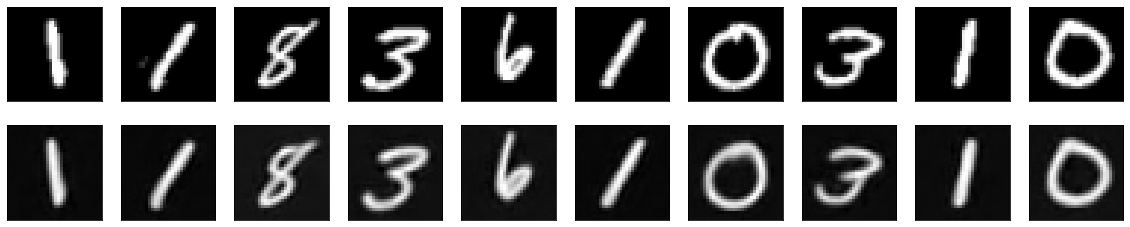

In [0]:
import matplotlib.pyplot as plt
starts=200
n = 10
decoded_imgs = Fr.predict(target['data'][starts:starts+n])
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original target
    ax = plt.subplot(2, n, i+1)
    plt.imshow(target['data'][i+starts].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction target
    ax = plt.subplot(2, n, n+i+1)
    plt.imshow(decoded_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

In [0]:
print('pred_label:')
print(np.argmax(Fc.predict(target['data'][starts:starts+n]),axis=1))
print('true_label:')
print(np.argmax(target['label'][starts:starts+n],axis=1))

pred_label:
[1 1 3 3 4 1 0 3 1 0]
true_label:
[1 1 8 3 6 1 0 3 1 0]


In [0]:
pred_score=Fc.predict(target['data'][starts:starts+n])
pred_label=np.argmax(pred_score,axis=1)
true_label=np.argmax(target['label'][starts:starts+n],axis=1)
for i in range(n):
    print('confidence of prediction:')
    print(pred_score[i][pred_label[i]])
    print('confidence of true label:')
    print(pred_score[i][true_label[i]])

confidence of prediction:
1.0
confidence of true label:
1.0
confidence of prediction:
0.8738173
confidence of true label:
0.8738173
confidence of prediction:
0.984463
confidence of true label:
0.01427096
confidence of prediction:
1.0
confidence of true label:
1.0
confidence of prediction:
0.92467356
confidence of true label:
0.07433131
confidence of prediction:
0.9719767
confidence of true label:
0.9719767
confidence of prediction:
1.0
confidence of true label:
1.0
confidence of prediction:
0.945623
confidence of true label:
0.945623
confidence of prediction:
1.0
confidence of true label:
1.0
confidence of prediction:
1.0
confidence of true label:
1.0


In [0]:
# By definition a confusion matrix is such that is equal to the number of
# observations known to be in group i but predicted to be in group j.(i,j)
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(np.argmax(target['label'],1),np.argmax(Fc.predict(target['data']),1))
conf_mx

array([[5396,   10,  603,   64,  512,    2,   51,    6,  258,    1],
       [   0, 7421,    2,    0,  429,    0,    0,   25,    0,    0],
       [ 110,  215, 3769, 1377,  728,   81,   38,  229,  368,   75],
       [   5,   27,   45, 6856,   36,   91,    3,   22,   26,   30],
       [   2,  411,    2,    8, 5913,    1,   14,  180,    4,  289],
       [   4,  214,   15, 1000,  340, 4521,  176,    0,    6,   37],
       [ 321,   63,   47,   63, 3724,    4, 2634,    6,   11,    3],
       [  94,  595,  194,   38,  202,   81,   22, 6008,    0,   59],
       [   5,  761,  105, 1105,  217,  109,  181,  156, 3807,  379],
       [  54,  741,   29,   56, 1786,  212,   20,  855,   15, 3190]])

In [0]:
np.shape(source['data'])

(300000, 32, 32, 1)